In [1]:
library(Seurat)
library(tidyverse)
library(foreach)
library(doParallel)
library(ggpubr)
source("/shareb//zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
library(ComplexHeatmap)
options(bedtools.path = "~/miniconda3/envs/py3/bin")
library(bedtoolsr)
options(scipen=999)

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘foreach’


The followin

In [2]:
hires <- readRDS("../../hires_mouse_emb_dev.new.rds")

In [49]:
allgadi_bedpe <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/hires_emb_gadi.tsv.gz")

Rows: 390252 Columns: 12
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (5): chrom1, chrom2, name, pos, GADI_id
dbl (7): start1, end1, start2, end2, cor, pv, fdr_cor

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6", 
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","early neurons"="#1F62A6","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C","mix late mesenchyme"="#BD342F",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5"
)
cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

In [5]:
hires <- subset(hires,subset = celltype != "mitosis" & celltype != "ExE ectoderm" & celltype != "ExE endoderm" & cellcycle_threshold != "M" & celltype != "blood")
DefaultAssay(hires) <- "SCT"
Idents(hires)<- hires$celltype
neuron_markers <- FindMarkers(hires,`ident.1` = "early neurons",only.pos = T) %>% filter(p_val_adj < 0.01)
mesenchyme_markers <- FindMarkers(hires,`ident.1` = "mix late mesenchyme",only.pos = T) %>% filter(p_val_adj < 0.01)

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from cpg_umap_ to cpgumap_”
Warning message:
“Cannot add objects with duplicate keys (offending key: cpgumap_) setting key to original value 'cpg_umap_'”


In [6]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","gene","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(gene) %>% slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
# functions
overlap_ratio <- function(bedpe,bed){
    bed <- bed %>% select(1:3)
    names(bed) <- c("chrom","start","end")
    
    bed1_l <- bedpe %>% select(1:3)
    bed1_r <- bedpe %>% select(4:6)

    names(bed1_l) <- c("chrom","start","end")
    names(bed1_r) <- c("chrom","start","end")
    names(bed) <- c("chrom","start","end")
    
    bed1_l_intersect <- valr::bed_intersect(bed1_l%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    bed1_r_intersect <- valr::bed_intersect(bed1_r%>% mutate(id = row_number()),bed)  %>% select(1:4) %>% unique()
    
    intersected <- full_join(bed1_l_intersect,bed1_r_intersect,by="id.x")
    a=dim(intersected %>% filter(chrom.x == chrom.y))[1]
    b=dim(intersected)[1]
    c=dim(bedpe)[1]
    return(c(a/c,b/c))
}

dynamic_postprocess <- function(dynamics){
    temp <- dynamics %>%  group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% group_by(type) %>% mutate(id = row_number()) %>% spread(type,norm_value)  %>% mutate(residue = GADI - RNA) %>% na.omit()  %>%
      group_by(gene,gadi) 
    testres = temp %>% group_by(gene,gadi) %>% summarise(residual = mean(GADI-RNA),pv = t.test(GADI-RNA,mu=0)$p.value,t=t.test(GADI-RNA,mu=0)$statistic) %>% ungroup()
    testres <- testres %>% group_by(gene)  %>% mutate(fdr = p.adjust(pv,method="BH")) %>% 
        mutate(type = ifelse(sign(t)==1,"early","lag"),sigtype = ifelse(fdr < 0.05,"sig","not")) 
    testres %>% mutate(test_type = ifelse(sigtype == "sig",type,"notSig"))%>% mutate(gaditype = str_extract(gadi,"neg|pos"),gadi=str_remove_all(gadi,"pos|neg")) %>% 
        separate(gadi,into = c("chrom","bin1","bin2")) %>% mutate(bin1 = as.numeric(bin1),bin2 = as.numeric(bin2)) %>% 
        mutate(start1=bin1 - 10000,start2=bin2-10000,end1 = bin1 + 10000,end2 = bin2+ 10000,chrom1 = chrom,chrom2 = chrom) %>% 
        select(chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,t,gene) %>% ungroup() -> testres
    return(testres)
}

plot_dynamic_enrichment <- function (testRes, gadi_type, feature_bed, title, numbin = 100, 
    outdir = "residual_enrichment", save = FALSE,type ="one") 
{
    feature = deparse(substitute(feature_bed))
    neural_testRes_rank <- testRes %>% filter(gaditype == gadi_type) %>% 
        arrange(desc(residual)) %>% mutate(rankgroup = ntile(seq(n()), 
        numbin)) %>% ungroup()
    types <- neural_testRes_rank %>% group_by(rankgroup, test_type) %>% 
        mutate(votes = n()) %>% group_by(rankgroup) %>% summarise(majority_vote = test_type[votes > 
        n()/2][1]) %>% pull(majority_vote)
    if(type == "one"){
        residual_enrich <- map(seq(numbin), function(x) {
            overlap_ratio(neural_testRes_rank %>% filter(rankgroup == 
                x), feature_bed)[2]
        }) %>% unlist()
        print("one")
    }else{
         print("both")
        residual_enrich <- map(seq(numbin), function(x) {
                overlap_ratio(neural_testRes_rank %>% filter(rankgroup == 
                    x), feature_bed)[1]
            }) %>% unlist()
    }
    options(repr.plot.width = 4.5, repr.plot.height = 5, repr.plot.res = 200)
    p <- cbind(seq(numbin), types, residual_enrich) %>% as.data.frame() %>% 
        mutate(V1 = as.numeric(V1), residual_enrich = as.numeric(residual_enrich)) %>% 
        mutate(types = ifelse(types == "early", "Proceeding", 
            ifelse(types == "lag", "Succeeding", "Not Sig"))) %>% 
        ggscatter(x = "V1", y = "residual_enrich", color = "types", size = 0.1,
            palette = c(Proceeding = "#b2182b", `Not Sig` = "#969696", 
                Succeeding = "#2166ac")) + ylab(paste0("percent of ", 
        feature)) + xlab("residual group rank") + theme_Publication() + 
        ggtitle(title)
    if (save == FALSE) {
        p %>% ggsave(filename = paste0(outdir, "/", title, "_", 
            feature, ".svg"), width = 4.5, height = 5)
    }
    return(p)
}

In [8]:
mesen_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/residuals_dynamic.mesen.rds.gz")
neural_dynamics <- readRDS("/shareb/zliu/analysis/hires_mouse_dev/figure3_related_new/di_emb_nonp/residuals_dynamic.neu.rds.gz")
neural_testRes <- dynamic_postprocess(neural_dynamics)
mesen_testRes <- dynamic_postprocess(mesen_dynamics)

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.


In [137]:
40990/189993

[1] 0.2157448

In [140]:
rbind(neural_testRes,mesen_testRes) %>% filter(test_type =="lag") # select(gene) %>% unique()

chrom1,start1,end1,chrom2,start2,end2,gaditype,test_type,residual,pv,fdr,t,gene
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
chr13,28270000,28290000,chr13,28790000,28810000,pos,lag,-0.3258809,0.000042200039,0.00022308389,-4.413518,2610307P16Rik
chr13,28310000,28330000,chr13,28710000,28730000,pos,lag,-0.3924960,0.000005039356,0.00006399951,-5.005186,2610307P16Rik
chr13,28310000,28330000,chr13,28730000,28750000,pos,lag,-0.3823578,0.000009210847,0.00008848993,-4.840159,2610307P16Rik
chr13,28310000,28330000,chr13,28750000,28770000,pos,lag,-0.3406702,0.000023685605,0.00015540068,-4.577312,2610307P16Rik
chr13,28310000,28330000,chr13,28770000,28790000,pos,lag,-0.3220304,0.000042294716,0.00022308389,-4.412877,2610307P16Rik
chr13,28310000,28330000,chr13,28790000,28810000,pos,lag,-0.3090100,0.000082457896,0.00037418929,-4.220156,2610307P16Rik
chr13,28310000,28330000,chr13,28810000,28830000,pos,lag,-0.3151164,0.000079141878,0.00036705457,-4.232118,2610307P16Rik
chr13,28310000,28330000,chr13,28830000,28850000,pos,lag,-0.3450435,0.000023461540,0.00015540068,-4.579987,2610307P16Rik
chr13,28330000,28350000,chr13,28530000,28550000,pos,lag,-0.2129415,0.017364457202,0.02942194019,-2.445546,2610307P16Rik


In [10]:
neural_testRes%>%filter(test_type == "early") %>% group_by(gaditype) %>% summarise(count = n()) %>%
 mutate(gaditype = ifelse(gaditype == "neg","pos.cor.","neg.cor."))

mesen_testRes%>%filter(test_type == "early") %>% group_by(gaditype) %>% summarise(count = n()) %>%
 mutate(gaditype = ifelse(gaditype == "neg","pos.cor.","neg.cor."))

gaditype,count
<chr>,<int>
pos.cor.,9483
neg.cor.,5688


gaditype,count
<chr>,<int>
pos.cor.,20375
neg.cor.,5444


In [11]:
neural_testRes %>% group_by(gaditype,test_type,gene) %>% summarise(count = n()) %>% 
    filter(test_type == "early") %>% filter(count > 10) %>% group_by(test_type,gaditype) %>% summarise(count = n()) %>% 
    mutate(gaditype = ifelse(gaditype == "neg","pos.cor.","neg.cor."))

`summarise()` has grouped output by 'gaditype', 'test_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'test_type'. You can override using the `.groups` argument.


test_type,gaditype,count
<chr>,<chr>,<int>
early,pos.cor.,95
early,neg.cor.,56


In [12]:
mesen_testRes %>% group_by(gaditype,test_type,gene) %>% summarise(count = n()) %>% 
    filter(test_type == "early") %>% filter(count > 10) %>% group_by(test_type,gaditype) %>% summarise(count = n()) %>% 
     mutate(gaditype = ifelse(gaditype == "neg","pos.cor.","neg.cor."))

`summarise()` has grouped output by 'gaditype', 'test_type'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'test_type'. You can override using the `.groups` argument.


test_type,gaditype,count
<chr>,<chr>,<int>
early,pos.cor.,130
early,neg.cor.,51


Warning message:
“Using `bins = 30` by default. Pick better value with the argument `bins`.”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


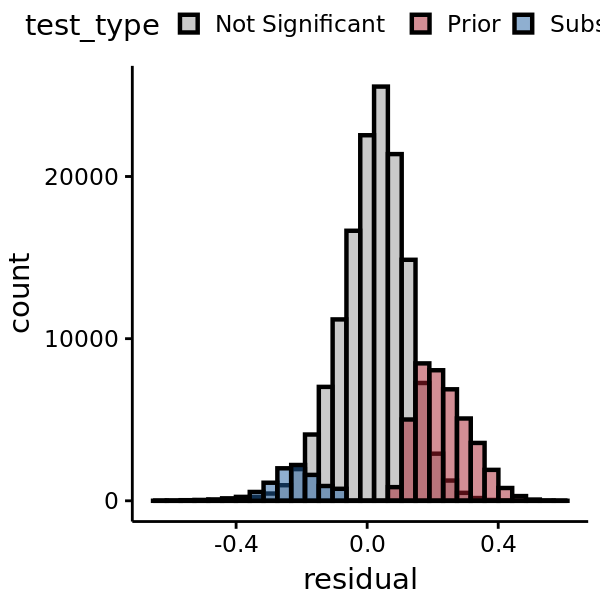

In [14]:
options(repr.plot.width = 2,repr.plot.height=2,repr.plot.res= 300)
p <- rbind(neural_testRes,mesen_testRes) %>% mutate(test_type = ifelse(fdr < 0.05,test_type,"Not Significant"))%>% 
    mutate(test_type=ifelse(test_type == "early","Prior",test_type)) %>% 
    mutate(test_type=ifelse(test_type == "lag","Subsequent",test_type)) %>%
    gghistogram(x="residual",fill="test_type",palette = c("#969696","#a81e2c","#2161a2")) + theme_Publication()
p

In [15]:
p %>% ggsave(filename = "residual_hist.pdf",height = 2, width =2,dpi=300,units ="in")

In [16]:
# data for enrichmetn analysis 
neuron_compartment <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/early_neurons.compartment.100k.bed",col_names = c("chrom","start","end","type"))
neuron_b <- neuron_compartment %>% filter(type == "B")

mesenchyme_compartment <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/mix_late_mesenchyme.compartment.100k.bed",col_names = c("chrom","start","end","type"))
mesenchyme_b <- mesenchyme_compartment %>% filter(type == "B")

neuron_E1 <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/early_neurons.compartment.100k.cis.vecs.tsv")%>% select(chrom,start,end,E1) %>% na.omit()
mesenchyme_E1 <- read_tsv("/shareb/zliu/analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/mix_late_mesenchyme.compartment.100k.cis.vecs.tsv")%>% select(chrom,start,end,E1) %>% na.omit()

# load features track
forebrain_H3K27ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR275KPI_H3K27ac_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3) %>% suppressMessages() 
forebrain_atac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR273UFV_nan_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K9ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR400TGE_H3K9ac_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K4me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR739DVM_H3K4me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K9me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR894JAS_H3K9me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K27me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR944XPB_H3K27me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K4me1 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR975QSF_H3K4me1_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
forebrain_H3K36me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR066LZB_H3K36me3_forebrain_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 

limb_H3K27ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR897WBY_H3K27ac_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_atac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR377YDY_nan_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K9ac <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR286IGS_H3K9ac_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K4me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR654VMK_H3K4me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K9me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR961MEP_H3K9me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K27me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR085EYQ_H3K27me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K4me1 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR548BCO_H3K4me1_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 
limb_H3K36me3 <- read_tsv("/share/Data/mliu/project1/histone_data/ENCSR871YCT_H3K36me3_limb_e115.bed.gz",col_names = FALSE) %>% select(1:3)%>% suppressMessages() 

Rows: 1464 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1508 Columns: 4
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): chrom, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this da

In [17]:
options(repr.plot.width = 4.5,repr.plot.height=5,repr.plot.res= 200)
ahead <- neural_dynamics %>% filter(gene == "Nova2",gadi == "chr7-18920000-19320000neg") %>% 
    group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=pseudotime,y=norm_value,color=type))+ geom_smooth(aes(group=type),level = 0.95) + theme_Publication() + ggtitle("") + ylab("norm value") + NoLegend()

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [18]:
options(repr.plot.width = 4.5,repr.plot.height=5,repr.plot.res= 200)
lag <- neural_dynamics %>% filter(gene == "Zeb1",gadi == "chr18-5680000-6000000neg") %>% 
    group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=pseudotime,y=norm_value,color=type))+ 
    geom_smooth(aes(group=type)) + theme_Publication() + ggtitle("") + ylab("norm value") + theme(legend.position = "right",legend.direction = "vertical")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


In [19]:
options(repr.plot.width = 4.5,repr.plot.height=5,repr.plot.res= 200)
simo <- neural_dynamics %>% filter(gene == "Dcc",gadi == "chr18-72440000-73200000neg") %>% 
    group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
     select(-c(value,fitted_raw,fitted,high,low)) %>% 
    group_by(type)  %>% ggplot(aes(x=pseudotime,y=norm_value,color=type))+ geom_smooth(aes(group=type)) + theme_Publication() +
    ggtitle("") + ylab("norm value") + NoLegend()

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



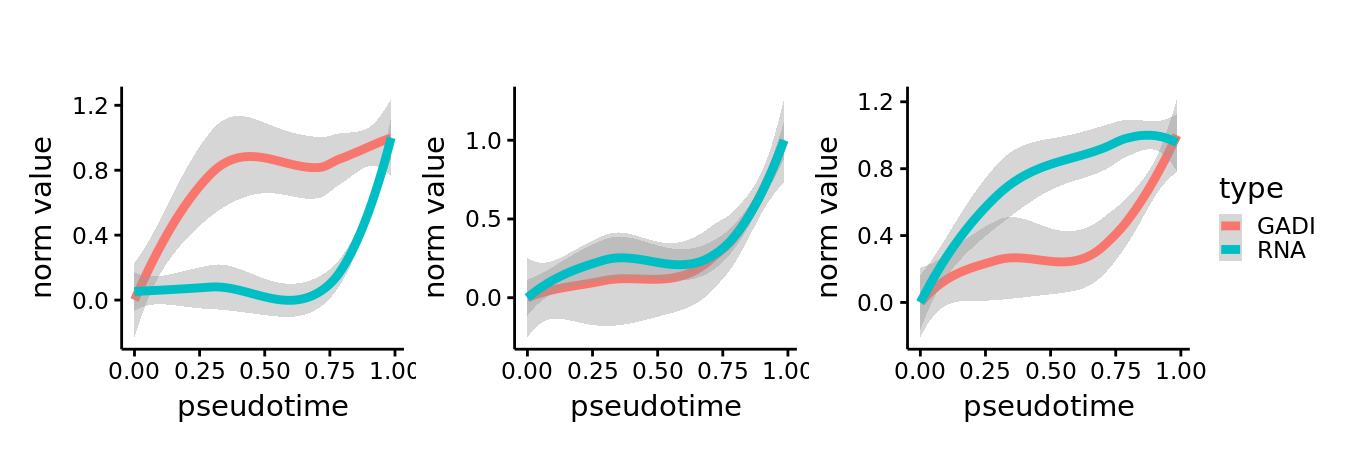

In [25]:
options(repr.plot.width = 4.5,repr.plot.height=1.5,repr.plot.res= 300)
(ahead | simo | lag) 
(ahead | simo | lag) %>% ggsave(filename = "ahead.pdf",height = 1.5, width =4.5,dpi=300,units ="in")

In [26]:
neural_testRes %>% group_by(gaditype) %>% summarise(count = n())

gaditype,count
<chr>,<int>
neg,61128
pos,25826


In [28]:
a <- plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K27ac,"Pos corr, neural,H3K27ac",type="one") + NoLegend() + xlab("") + ylab("") + ggtitle("")+scale_y_continuous(n.breaks = 4)#breaks = c(0.2,0.3,0.4,0.5),limits = c(0.1,0.55))

[1] "one"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


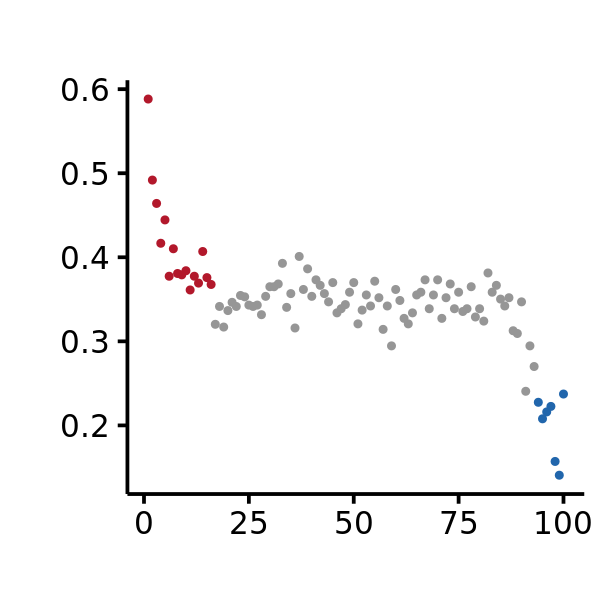

In [29]:
options(repr.plot.width = 1.5,repr.plot.height=1.5,repr.plot.res= 400)
a

In [68]:
# here gadi type is the opposite of correlation type
# line1
a <- plot_dynamic_enrichment(neural_testRes,"neg",forebrain_H3K27ac,"Pos corr, neural,H3K27ac",type="one") + NoLegend() + xlab("") + ylab("") + ggtitle("")+scale_y_continuous(breaks = c(0,0.2,0.4,0.6),limits = c(0,0.6))
b <- plot_dynamic_enrichment(neural_testRes,"pos",forebrain_H3K27ac,"Neg corr, neural,H3K27ac",type="one") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(breaks = c(0.2,0.3,0.4,0.5),limits = c(0.2,0.5))
c <- plot_dynamic_enrichment(mesen_testRes,"neg",limb_H3K27ac,"Pos corr, mesen,H3K27ac",type="one") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(breaks = c(0.2,0.3,0.4,0.5),limits = c(0.2,0.5))
d <- plot_dynamic_enrichment(mesen_testRes,"pos",limb_H3K27ac,"Neg corr, mesen,H3K27ac",type="one") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(n.breaks = 4)

# line2
e <- plot_dynamic_enrichment(neural_testRes,"neg",neuron_b,"Pos corr, neural,BB",type="both") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(n.breaks = 4)
f <- plot_dynamic_enrichment(neural_testRes,"pos",neuron_b,"Neg corr, neural,BB",type="both") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(breaks = c(0,0.3,0.6,0.9),limits = c(0,0.9))
g <- plot_dynamic_enrichment(mesen_testRes,"neg",mesenchyme_b,"Pos corr, mesen,BB",type="both") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(breaks = c(0,0.1,0.2,0.3),limits = c(0,0.35))
h <- plot_dynamic_enrichment(mesen_testRes,"pos",mesenchyme_b,"Neg corr, mesen,BB",type="both") + NoLegend() + xlab("") + ylab("")+ ggtitle("")+scale_y_continuous(breaks = c(0,0.2,0.4,0.6),limits = c(0,0.6))

[1] "one"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "one"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "one"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "one"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "both"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "both"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "both"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


[1] "both"


Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


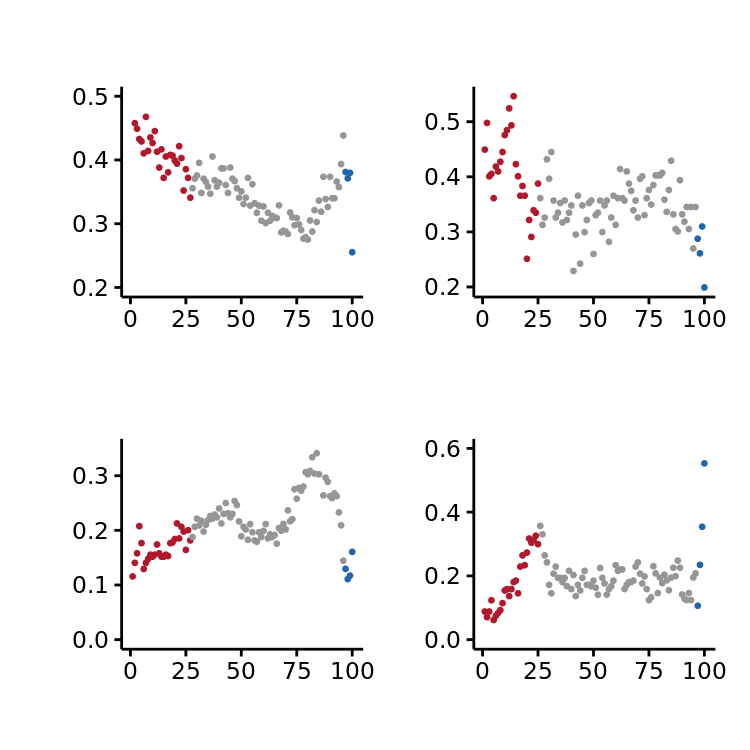

In [69]:
options(repr.plot.width = 2.5,repr.plot.height=2.5,repr.plot.res= 300)
((c|d)/(g|h))

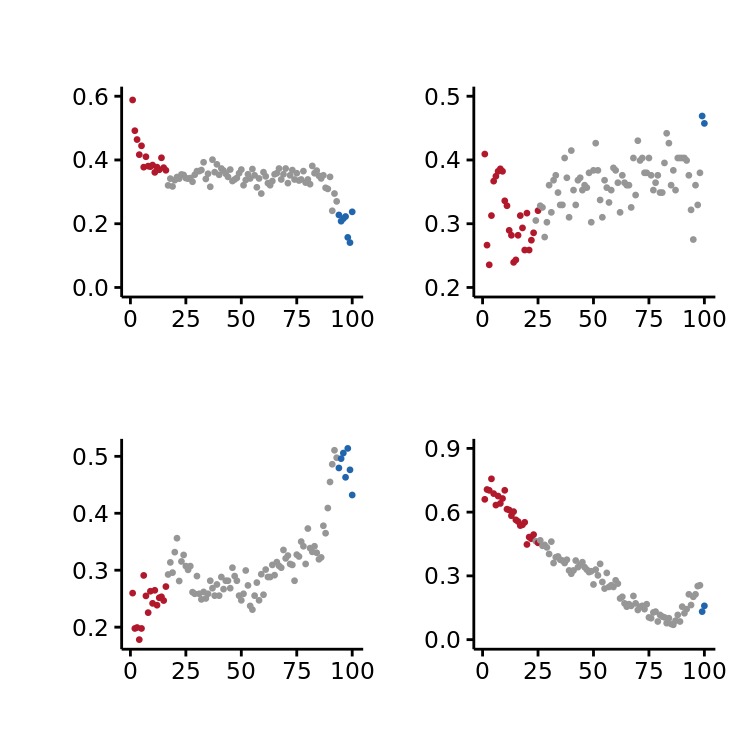

In [70]:
((a|b)/(e|f))

In [71]:
options(repr.plot.width = 4,repr.plot.height=2,repr.plot.res= 300)
((c|d)/(g|h)) %>% ggsave(filename = "scatterenrich_mesen.pdf",height = 2.5, width =2.5,dpi=300,units ="in")
((a|b)/(e|f)) %>% ggsave(filename = "scatterenrich_neuron.pdf",height = 2.5, width =2.5,dpi=300,units ="in")

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


In [33]:
mc_hires <- readRDS("../../figure3_related_new/di_emb_nonp/hires_emb_metacell.rds")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


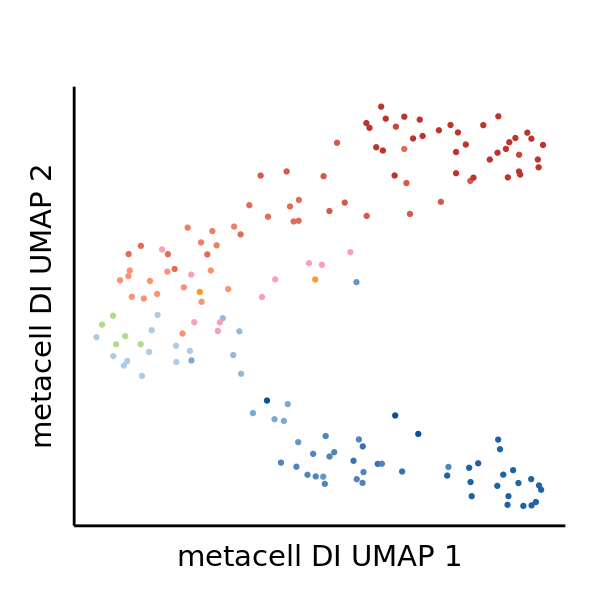

In [36]:
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
p <- DimPlot(mc_hires,group.by = "celltype",cols = celltypeColors,reduction = "mcdi_umap",label=F,pt.size = 0.05) + NoLegend() 
p <- p +theme_Publication() + NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("metacell DI UMAP 1") + ylab("metacell DI UMAP 2") + ggtitle("")
p
p %>% ggsave(filename = "umap_mcdi.pdf",height = 2, width =2,dpi=300,units ="in")

In [37]:
p<-FeaturePlot(mc_hires,features = "mcsct_Nova2", reduction = "mcdi_umap",label=F,pt.size = 1,slot = "scale.data")
q<-FeaturePlot(mc_hires,features = "mcdi_chr7-18920000-19320000", reduction = "mcdi_umap",label=F,pt.size = 1,slot = "scale.data")

In [52]:
allgadi_bedpe %>% filter(pos == "chr7-18920000-19320000")

chrom1,start1,end1,chrom2,start2,end2,name,cor,pv,fdr_cor,pos,GADI_id
<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
chr7,18910000,18930000,chr7,19310000,19330000,Fosb,0.4062433,0.0000001183391,0.000001081849,chr7-18920000-19320000,GADI_104382
chr7,18910000,18930000,chr7,19310000,19330000,Nectin2,0.3487156,0.0000071139965,0.000043143621,chr7-18920000-19320000,GADI_253977
chr7,18910000,18930000,chr7,19310000,19330000,Nova2,-0.3752617,0.0000011842563,0.000008614203,chr7-18920000-19320000,GADI_261077


In [38]:
plotdata <- cbind(p$data,q$data%>% select(-c(1:3))) 
names(plotdata) <- c("umap1","umap2","ident","RNA","GADI")
plotdata %>% mutate(GADI = - GADI) -> plotdata
#plotdata %>% mutate(RNA = rank(RNA)/n(),GADI = rank(GADI)/n()) -> # %>% mutate(RNA = ifelse(RNA < 0.3, 0.3,RNA),
                                                                     #    GADI = ifelse(GADI < 0.3, 0.3,GADI)) -> plotdata

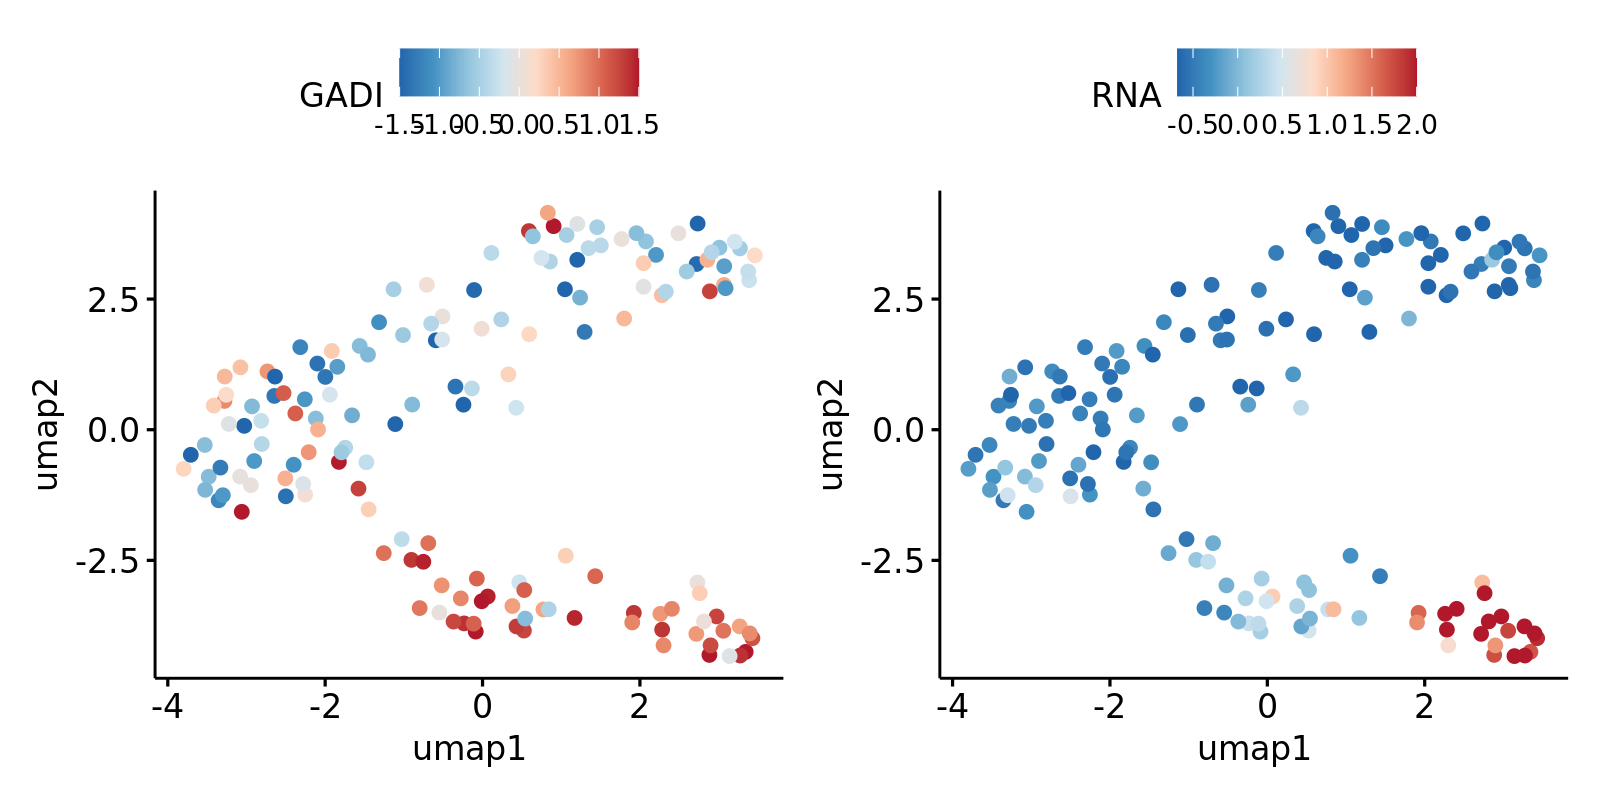

In [39]:
a <- plotdata %>% mutate(GADI = ifelse(GADI < -1.5, -1.5,GADI),GADI = ifelse(GADI > 1.5, 1.5,GADI)  )%>% 
ggscatter(x="umap1",y="umap2",color = "GADI") + 
  scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac')))

b <- plotdata %>% mutate(RNA = ifelse(RNA < -2, -2,RNA),RNA = ifelse(RNA > 2, 2,RNA))%>%
    ggscatter(x="umap1",y="umap2",color = "RNA") + 
  scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac'))) 

options(repr.plot.height = 4, repr.plot.width = 8 ,repr.plot.res = 200)
a | b

In [40]:
calc_dynamic <-  function(object,gene,gadi,key,slot1="mc_sct",slot2="gadis",correlation = "pos"){
    RNA_temp <- object[[slot1]]@data[gene,]
    if(correlation=="pos"){
        GADI_temp <- object[[slot2]]@data[gadi,]
    }
    else{
        GADI_temp <- -object[[slot2]]@data[gadi,]
    }
    tempData <- cbind(RNA_temp,GADI_temp,object[[]] %>% select(all_of(key)) %>% pull(1)) %>% as.data.frame() 
    names(tempData) <- c("RNA","GADI","pseudotime")
    #tempData <- tempData %>% filter(pseudotime > 0.4)
    tempData <- tempData %>% gather(type,value,-pseudotime)
    tempData[is.na(tempData)] <- 0

    tempData <- tempData %>% group_by(type) %>% mutate(fitted_raw = predict(loess(value ~ pseudotime), se=T)$fit,fitted = (fitted_raw - min(fitted_raw))/(max(fitted_raw)-min(fitted_raw)),
                                          high = fitted + qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, high = (high - min(high))/(max(high)-min(high)),
                                          low = fitted - qt(0.975,predict(loess(value ~ pseudotime), se=T)$df)*predict(loess(value ~ pseudotime), se=T)$se, low = (low - min(low))/(max(low)-min(low)))
    return(tempData %>% mutate(gene =gene,gadi=gadi))
}

In [41]:
mc_hires

An object of class Seurat 
571318 features across 158 samples within 2 assays 
Active assay: mc_di (535780 features, 0 variable features)
 1 other assay present: mc_sct
 4 dimensional reductions calculated: mcdi_pca, mcdi_umap, mcsct_pca, mcsct_umap

In [42]:
temp <- calc_dynamic(mc_hires,"Nova2",gadi="chr7-18920000-19320000",key="sct_pseudotime",slot2="mc_di",correlation="neg")

In [48]:
allgadi_bedpe

ERROR: Error in eval(expr, envir, enclos): object 'allgadi_bedpe' not found


In [43]:
pdata <- cbind(plotdata,mc_hires[[]] %>% select(sct_pseudotime)) %>% select(-c(ident,RNA,GADI)) %>% 
    mutate(pseudotime = sct_pseudotime) %>% left_join(temp)

Joining, by = "pseudotime"


In [44]:
head(pdata)

,umap1,umap2,sct_pseudotime,pseudotime,type,value,fitted_raw,fitted,high,low,gene,gadi
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.85667699,3.217699,0.7829365,0.7829365,RNA,0.0000000,0.1614404,0.3710769,0.3576685,0.3869583,Nova2,chr7-18920000-19320000
2,0.85667699,3.217699,0.7829365,0.7829365,GADI,-0.8521481,-0.5109163,0.9778693,0.9863816,0.9678443,Nova2,chr7-18920000-19320000
3,1.50303304,3.526463,0.9030290,0.9030290,RNA,0.0000000,0.2568061,0.6942844,0.6573326,0.7340165,Nova2,chr7-18920000-19320000
4,1.50303304,3.526463,0.9030290,0.9030290,GADI,-0.8243509,-0.5256559,0.9431445,0.9120414,0.9639400,Nova2,chr7-18920000-19320000
5,-0.08659953,-3.863574,0.8749865,0.8749865,RNA,0.2096268,0.2330960,0.6139274,0.5796283,0.6510963,Nova2,chr7-18920000-19320000
6,-0.08659953,-3.863574,0.8749865,0.8749865,GADI,0.2713506,-0.5123637,0.9744593,0.9491241,0.9906754,Nova2,chr7-18920000-19320000


In [45]:
options(repr.plot.height = 2, repr.plot.width = 2 ,repr.plot.res = 300)
p <- pdata %>% filter(type == "GADI")%>% group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
    mutate(norm_value = ifelse(norm_value > 2,2,norm_value),norm_value = ifelse(norm_value < 0,0,norm_value)) %>% 
    ggscatter(x="umap1",y="umap2",color = "norm_value",size = 1) + #facet_wrap(~type) + 
    scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac')))

p <- p + theme_Publication()+ NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("DI UMAP 1") + ylab("DI UMAP 2") + ggtitle("")

q <- pdata %>% filter(type == "RNA")%>% group_by(gene,gadi,type) %>% mutate(norm_value = (value - min(fitted_raw))/(max(fitted_raw) - min(fitted_raw))) %>% 
    mutate(norm_value = ifelse(norm_value > 2,2,norm_value),norm_value = ifelse(norm_value < 0,0,norm_value)) %>% 
    ggscatter(x="umap1",y="umap2",color = "norm_value",size = 1) + #facet_wrap(~type) + 
    scale_colour_gradientn(colours = rev(c('#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac')))

q <- q + theme_Publication()+ NoLegend()+ theme(axis.ticks.x = element_blank(),
        axis.text.x = element_blank(),
         axis.ticks.y = element_blank(),
          axis.text.y = element_blank()) + xlab("DI UMAP 1") + ylab("DI UMAP 2") + ggtitle("")

Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”
Warning message:
“`legend.margin` must be specified using `margin()`. For the old behavior use legend.spacing”


`geom_smooth()` using method = 'loess' and formula 'y ~ x'

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



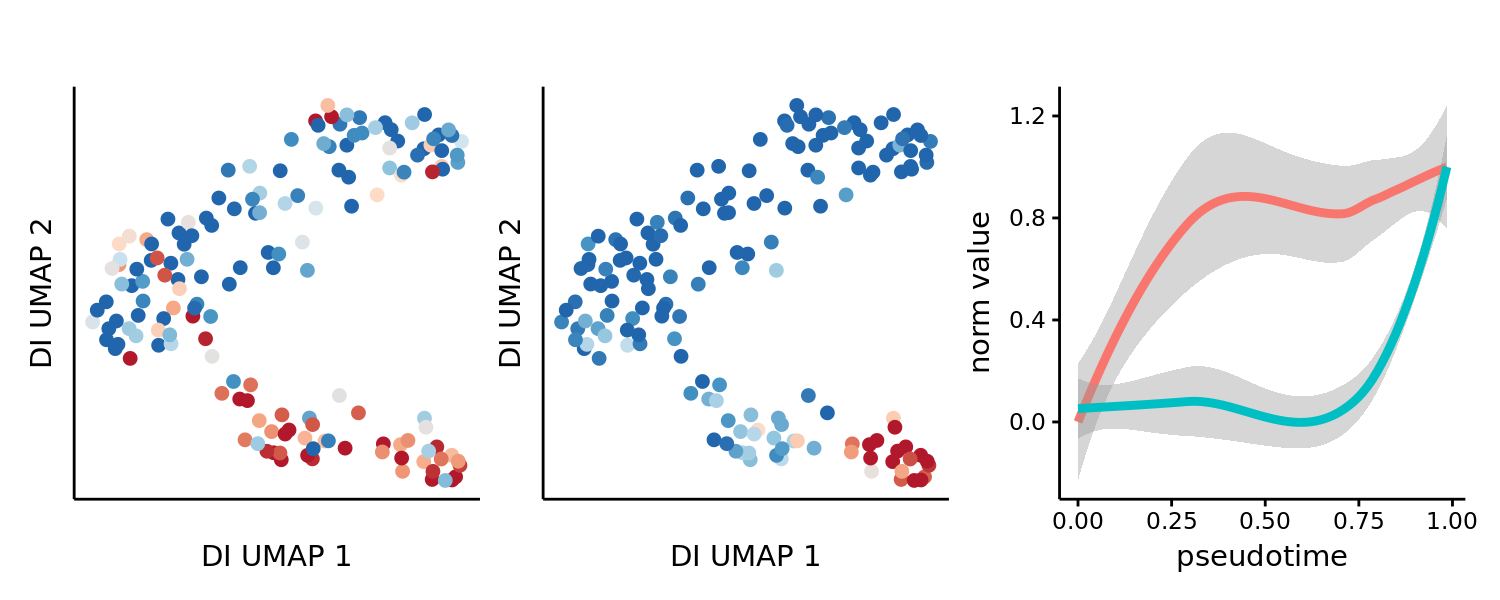

In [46]:
options(repr.plot.height = 2, repr.plot.width = 5 ,repr.plot.res = 300)
(p | q | ahead) #
(p | q | ahead)%>% ggsave(filename = "residual_example.pdf",height = 2, width =5,dpi=300,units ="in")

In [47]:
p %>% ggsave(filename = "residual_example_1.pdf",height = 2, width =2,dpi=300,units ="in")
q %>% ggsave(filename = "residual_example_2.pdf",height = 2, width =2,dpi=300,units ="in")
ahead %>% ggsave(filename = "residual_example_3.pdf",height = 2, width =2,dpi=300,units ="in")

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



In [99]:
alldi <- read_tsv("../../figure3_related_new/di_emb_nonp/alldis.filtered.tsv.gz")

Rows: 694384 Columns: 13
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom1, chrom2, pos, celltype
dbl (9): start1, end1, start2, end2, pv, FDR, diff, mat1_mean_all, mat2_mean...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
